In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Conv2DTranspose, BatchNormalization, Reshape
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

# Load CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Specify hyper-parameters
batch_size = 64
num_classes = 10
latent_dim = 100
num_epochs = 100
alpha = 1

# Convert datasets to floating point types
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalize the training and testing datasets
X_train /= 255.0
X_test /= 255.0

# Create TF datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(50000).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).shuffle(10000).batch(batch_size)

# Define the encoder
class Encoder(Model):
    def __init__(self, latent_dim=100):
        super(Encoder, self).__init__()
        self.conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')
        self.pool1 = MaxPooling2D((2, 2))
        self.conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')
        self.pool2 = MaxPooling2D((2, 2))
        self.conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')
        self.flatten = Flatten()
        self.dense_mean = Dense(latent_dim)
        self.dense_log_var = Dense(latent_dim)

    def call(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        mean = self.dense_mean(x)
        log_var = self.dense_log_var(x)
        return mean, log_var

# Define the decoder
class Decoder(Model):
    def __init__(self):
        super(Decoder, self).__init__()
        self.dense = Dense(4 * 4 * 256, activation='relu')
        self.reshape = Reshape((4, 4, 256))
        self.conv_transpose1 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')
        self.conv_transpose2 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')
        self.conv_transpose3 = Conv2DTranspose(3, (3, 3), strides=(2, 2), padding='same', activation='sigmoid')

    def call(self, x):
        x = self.dense(x)
        x = self.reshape(x)
        x = self.conv_transpose1(x)
        x = self.conv_transpose2(x)
        x = self.conv_transpose3(x)
        return x

# Define the CVAE
# Define the CVAE
class CVAE(Model):
    def __init__(self, latent_dim=100, num_classes=10):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.encoder = Encoder(latent_dim=self.latent_dim)
        self.decoder = Decoder()
        self.dense_labels = Dense(latent_dim + num_classes)

    def reparameterize(self, mean, log_var):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(log_var * 0.5) + mean

    def call(self, inputs):
        x, labels = inputs
        mean, log_var = self.encoder(x)
        z = self.reparameterize(mean, log_var)
        labels = tf.cast(labels, tf.float32)  # Cast labels to float32
        z_cond = tf.concat([z, labels], axis=1)
        reconstructed = self.decoder(z_cond)
        return reconstructed, mean, log_var

# Create an instance of CVAE
cvae = CVAE(latent_dim=latent_dim, num_classes=num_classes)

# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

# Define the loss function
def compute_loss(data, reconstruction, mu, log_var, alpha=1):
    # Expand dimensions to match expected shape for mean_squared_error
    data_expanded = tf.expand_dims(data, axis=-1)
    reconstruction_expanded = tf.expand_dims(reconstruction, axis=-1)

    recon_loss = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.mean_squared_error(data_expanded, reconstruction_expanded), axis=(1, 2, 3)))
    kl_loss = -0.5 * (1 + log_var - tf.square(mu) - tf.exp(log_var))
    kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
    total_loss = recon_loss + alpha * kl_loss
    return total_loss, recon_loss, kl_loss


# Define a function to train one step
@tf.function
def train_one_step(model, optimizer, data, labels, alpha):
    with tf.GradientTape() as tape:
        reconstructed, mu, log_var = model([data, labels])
        total_loss, recon_loss, kl_loss = compute_loss(data, reconstructed, mu, log_var, alpha)
    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return total_loss, recon_loss, kl_loss

# Training loop
for epoch in range(num_epochs):
    total_loss_avg = tf.keras.metrics.Mean()
    recon_loss_avg = tf.keras.metrics.Mean()
    kl_loss_avg = tf.keras.metrics.Mean()

    for data, labels in train_dataset:
        total_loss, recon_loss, kl_loss = train_one_step(cvae, optimizer, data, labels, alpha)
        total_loss_avg.update_state(total_loss)
        recon_loss_avg.update_state(recon_loss)
        kl_loss_avg.update_state(kl_loss)

    print(f'Epoch {epoch + 1}, Total Loss: {total_loss_avg.result()}, Recon Loss: {recon_loss_avg.result()}, KL Loss: {kl_loss_avg.result()}')


Epoch 1, Total Loss: 132.93345642089844, Recon Loss: 121.602783203125, KL Loss: 11.330609321594238
Epoch 2, Total Loss: 97.22467803955078, Recon Loss: 79.1216812133789, KL Loss: 18.103004455566406
Epoch 3, Total Loss: 86.13491821289062, Recon Loss: 66.82622528076172, KL Loss: 19.30873680114746
Epoch 4, Total Loss: 82.4433822631836, Recon Loss: 62.45466995239258, KL Loss: 19.988662719726562
Epoch 5, Total Loss: 81.16049194335938, Recon Loss: 60.65130615234375, KL Loss: 20.509233474731445
Epoch 6, Total Loss: 80.3107681274414, Recon Loss: 59.46987533569336, KL Loss: 20.840919494628906
Epoch 7, Total Loss: 79.58610534667969, Recon Loss: 58.550052642822266, KL Loss: 21.036027908325195
Epoch 8, Total Loss: 78.92276763916016, Recon Loss: 57.73096466064453, KL Loss: 21.191875457763672
Epoch 9, Total Loss: 78.37293243408203, Recon Loss: 57.08518981933594, KL Loss: 21.287744522094727
Epoch 10, Total Loss: 78.0057601928711, Recon Loss: 56.54043197631836, KL Loss: 21.465341567993164
Epoch 11, Tot

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Conv2DTranspose, BatchNormalization, Reshape
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

# Load CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Specify hyper-parameters
batch_size = 64
num_classes = 10
latent_dim = 100
num_epochs = 100
alpha = 1
learning_rate = 1e-4

# Convert datasets to floating point types
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalize the training and testing datasets
X_train /= 255.0
X_test /= 255.0

# Create TF datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(50000).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).shuffle(10000).batch(batch_size)

# Define the encoder
class Encoder(Model):
    def __init__(self, latent_dim=100):
        super(Encoder, self).__init__()
        self.conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')
        self.pool1 = MaxPooling2D((2, 2))
        self.conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')
        self.pool2 = MaxPooling2D((2, 2))
        self.conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')
        self.flatten = Flatten()
        self.dense_mean = Dense(latent_dim)
        self.dense_log_var = Dense(latent_dim)

    def call(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        mean = self.dense_mean(x)
        log_var = self.dense_log_var(x)
        return mean, log_var

# Define the decoder
class Decoder(Model):
    def __init__(self):
        super(Decoder, self).__init__()
        self.dense = Dense(4 * 4 * 256, activation='relu')
        self.reshape = Reshape((4, 4, 256))
        self.conv_transpose1 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')
        self.conv_transpose2 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')
        self.conv_transpose3 = Conv2DTranspose(3, (3, 3), strides=(2, 2), padding='same', activation='sigmoid')

    def call(self, x):
        x = self.dense(x)
        x = self.reshape(x)
        x = self.conv_transpose1(x)
        x = self.conv_transpose2(x)
        x = self.conv_transpose3(x)
        return x

# Define the CVAE
class CVAE(Model):
    def __init__(self, latent_dim=100, num_classes=10):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.encoder = Encoder(latent_dim=self.latent_dim)
        self.decoder = Decoder()
        self.dense_labels = Dense(latent_dim + num_classes)

    def reparameterize(self, mean, log_var):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(log_var * 0.5) + mean

    def call(self, inputs):
        x, labels = inputs
        mean, log_var = self.encoder(x)
        z = self.reparameterize(mean, log_var)
        labels = tf.cast(labels, tf.float32)  # Cast labels to float32
        z_cond = tf.concat([z, labels], axis=1)
        reconstructed = self.decoder(z_cond)
        return reconstructed, mean, log_var

# Create an instance of CVAE
cvae = CVAE(latent_dim=latent_dim, num_classes=num_classes)

# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Define the loss function
def compute_loss(data, reconstruction, mu, log_var, alpha=1):
    # Expand dimensions to match expected shape for mean_squared_error
    data_expanded = tf.expand_dims(data, axis=-1)
    reconstruction_expanded = tf.expand_dims(reconstruction, axis=-1)

    recon_loss = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.mean_squared_error(data_expanded, reconstruction_expanded), axis=(1, 2, 3)))
    kl_loss = -0.5 * (1 + log_var - tf.square(mu) - tf.exp(log_var))
    kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
    total_loss = recon_loss + alpha * kl_loss
    return total_loss, recon_loss, kl_loss

# Define a function to train one step
@tf.function
def train_one_step(model, optimizer, data, labels, alpha):
    with tf.GradientTape() as tape:
        reconstructed, mu, log_var = model([data, labels])
        total_loss, recon_loss, kl_loss = compute_loss(data, reconstructed, mu, log_var, alpha)
    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return total_loss, recon_loss, kl_loss

# Arrays to store losses for plotting
kl_loss_array = []
recon_loss_array = []

# Training loop
for epoch in range(num_epochs):
    total_loss_avg = tf.keras.metrics.Mean()
    recon_loss_avg = tf.keras.metrics.Mean()
    kl_loss_avg = tf.keras.metrics.Mean()

    for data, labels in train_dataset:
        total_loss, recon_loss, kl_loss = train_one_step(cvae, optimizer, data, labels, alpha)
        total_loss_avg.update_state(total_loss)
        recon_loss_avg.update_state(recon_loss)
        kl_loss_avg.update_state(kl_loss)

    kl_loss_array.append(kl_loss_avg.result())
    recon_loss_array.append(recon_loss_avg.result())

    print(f'Epoch {epoch + 1}, Total Loss: {total_loss_avg.result()}, Recon Loss: {recon_loss_avg.result()}, KL Loss: {kl_loss_avg.result()}')


Epoch 1, Total Loss: 131.486328125, Recon Loss: 119.9422836303711, KL Loss: 11.544156074523926
Epoch 2, Total Loss: 96.92444610595703, Recon Loss: 78.29418182373047, KL Loss: 18.63030433654785
Epoch 3, Total Loss: 85.639404296875, Recon Loss: 65.78349304199219, KL Loss: 19.85590171813965
Epoch 4, Total Loss: 82.63877868652344, Recon Loss: 62.273712158203125, KL Loss: 20.36507797241211
Epoch 5, Total Loss: 81.44075012207031, Recon Loss: 60.67124938964844, KL Loss: 20.76947593688965
Epoch 6, Total Loss: 80.66448974609375, Recon Loss: 59.590301513671875, KL Loss: 21.07415199279785
Epoch 7, Total Loss: 79.9813232421875, Recon Loss: 58.70196533203125, KL Loss: 21.279294967651367
Epoch 8, Total Loss: 79.32315826416016, Recon Loss: 57.84852981567383, KL Loss: 21.474660873413086
Epoch 9, Total Loss: 78.67332458496094, Recon Loss: 57.15612030029297, KL Loss: 21.517175674438477
Epoch 10, Total Loss: 78.22928619384766, Recon Loss: 56.59915542602539, KL Loss: 21.630090713500977
Epoch 11, Total Los

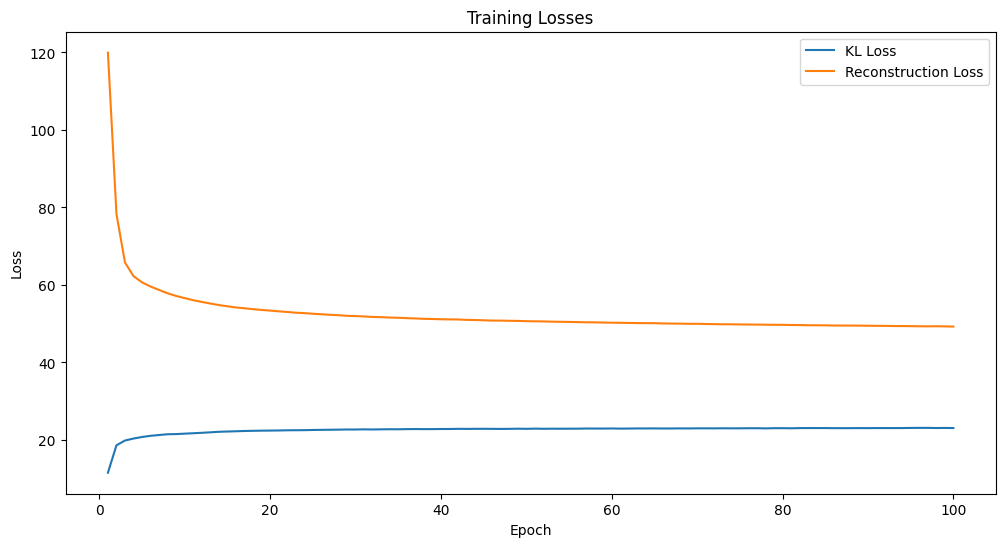

In [ ]:
# Plot KL and reconstruction loss
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), kl_loss_array, label='KL Loss')
plt.plot(range(1, num_epochs + 1), recon_loss_array, label='Reconstruction Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.show()

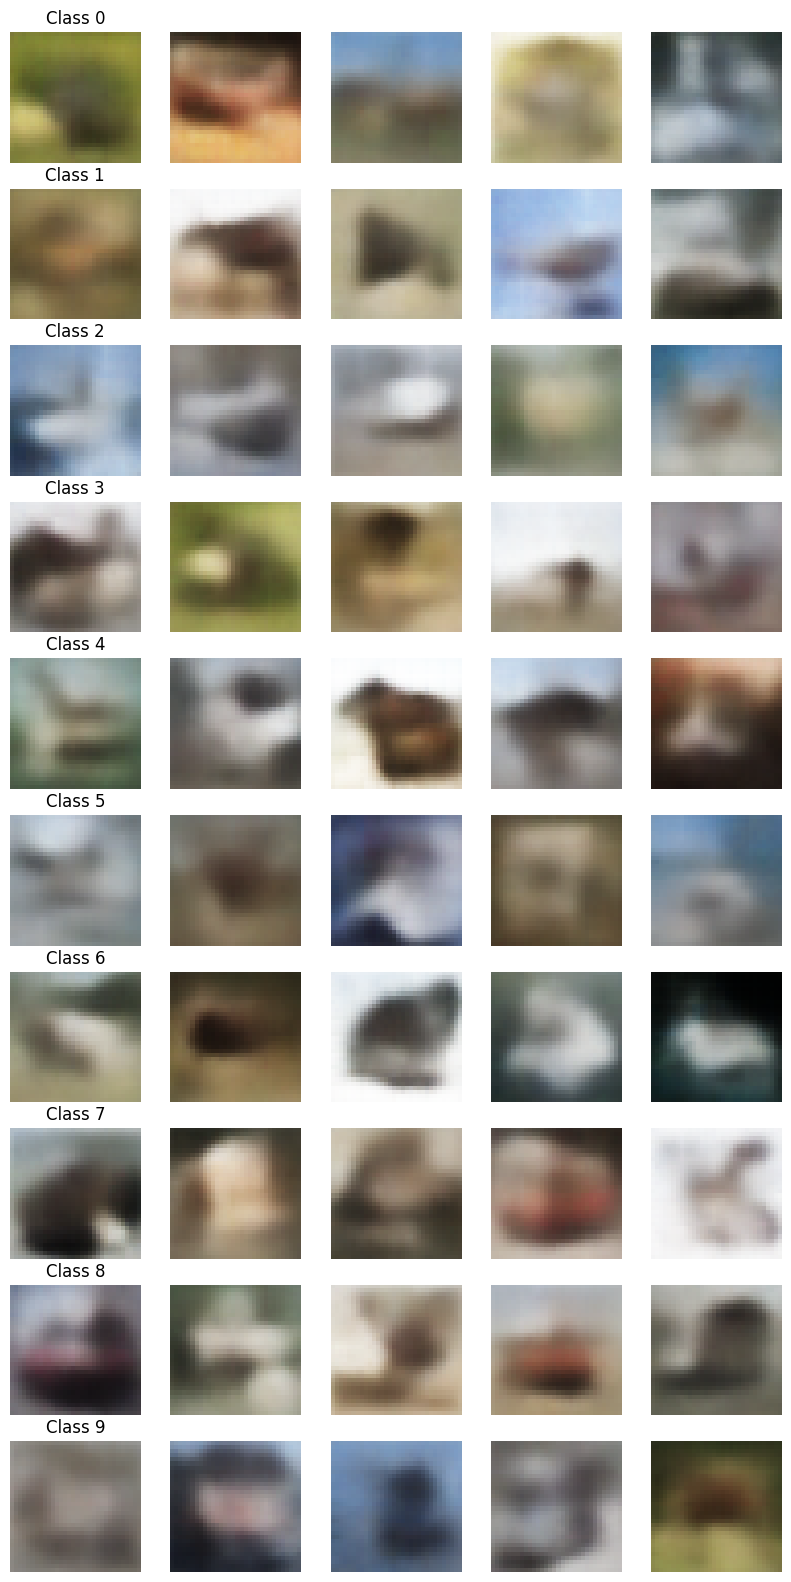

In [ ]:
# Generate and display images from each class of the CIFAR-10 dataset using the trained CVAE
def generate_images(model, num_images=5):
    fig, axs = plt.subplots(num_classes, num_images, figsize=(num_images * 2, num_classes * 2))
    for i in range(num_classes):
        for j in range(num_images):
            label = np.array([[i]])
            noise = np.random.normal(size=(1, latent_dim))
            z = np.concatenate([noise, label], axis=1)
            z = tf.convert_to_tensor(z, dtype=tf.float32)
            generated_image = model.decoder(z).numpy().squeeze()
            axs[i, j].imshow(generated_image)
            axs[i, j].axis('off')
            if j == 0:
                axs[i, j].set_title(f'Class {i}')
    plt.show()

# Generate images
generate_images(cvae)

In [ ]:
def train_one_step(learning_rate, latent_dim, train_dataset, num_epochs=100, alpha=1):
    # Create an instance of CVAE
    cvae = CVAE(latent_dim=latent_dim, num_classes=num_classes)

    # Define the optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Arrays to store losses for plotting
    kl_loss_array = []
    recon_loss_array = []

    # Training loop
    for epoch in range(num_epochs):
        total_loss_avg = tf.keras.metrics.Mean()
        recon_loss_avg = tf.keras.metrics.Mean()
        kl_loss_avg = tf.keras.metrics.Mean()

        for data, labels in train_dataset:
            with tf.GradientTape() as tape:
                reconstructed, mu, log_var = cvae([data, labels])
                total_loss, recon_loss, kl_loss = compute_loss(data, reconstructed, mu, log_var, alpha)
            gradients = tape.gradient(total_loss, cvae.trainable_variables)
            optimizer.apply_gradients(zip(gradients, cvae.trainable_variables))

            total_loss_avg.update_state(total_loss)
            recon_loss_avg.update_state(recon_loss)
            kl_loss_avg.update_state(kl_loss)

        kl_loss_array.append(kl_loss_avg.result())
        recon_loss_array.append(recon_loss_avg.result())

    return kl_loss_array, recon_loss_array

def hyperparameter_tuning(learning_rates, latent_dims, train_dataset):
    results = {}
    for lr in learning_rates:
        for latent_dim in latent_dims:
            print(f'Training with learning rate: {lr}, latent dimension: {latent_dim}')
            kl_losses, recon_losses = train_one_step(lr, latent_dim, train_dataset)
            results[(lr, latent_dim)] = (kl_losses, recon_losses)
    return results

# Define hyperparameters to tune
learning_rates = [1e-3, 5e-4, 1e-4]
latent_dims = [50, 100, 150]

# Perform hyperparameter tuning
results = hyperparameter_tuning(learning_rates, latent_dims, train_dataset)

# Print results
for params, (kl_losses, recon_losses) in results.items():
    print(f'Learning rate: {params[0]}, Latent dim: {params[1]} - KL Loss: {kl_losses[-1]}, Recon Loss: {recon_losses[-1]}')


Training with learning rate: 0.001, latent dimension: 50


Hyperparameter tuning

In [ ]:
# perform hyperparameter tuning through loops

def train_one_step(learning_rate, latent_dim, train_dataset, num_epochs=100, alpha=1):
    # Create an instance of CVAE
    cvae = CVAE(latent_dim=latent_dim, num_classes=num_classes)

    # Define the optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Arrays to store losses for plotting
    kl_loss_array = []
    recon_loss_array = []

    # Training loop
    for epoch in range(num_epochs):
        total_loss_avg = tf.keras.metrics.Mean()
        recon_loss_avg = tf.keras.metrics.Mean()
        kl_loss_avg = tf.keras.metrics.Mean()

        for data, labels in train_dataset:
            with tf.GradientTape() as tape:
                reconstructed, mu, log_var = cvae([data, labels])
                total_loss, recon_loss, kl_loss = compute_loss(data, reconstructed, mu, log_var, alpha)
            gradients = tape.gradient(total_loss, cvae.trainable_variables)
            optimizer.apply_gradients(zip(gradients, cvae.trainable_variables))

            total_loss_avg.update_state(total_loss)
            recon_loss_avg.update_state(recon_loss)
            kl_loss_avg.update_state(kl_loss)

        kl_loss_array.append(kl_loss_avg.result())
        recon_loss_array.append(recon_loss_avg.result())

    return kl_loss_array, recon_loss_array

def hyperparameter_tuning(learning_rates, latent_dims, train_dataset):
    results = {}
    for lr in learning_rates:
        for latent_dim in latent_dims:
            print(f'Training with learning rate: {lr}, latent dimension: {latent_dim}')
            kl_losses, recon_losses = train_one_step(lr, latent_dim, train_dataset)
            results[(lr, latent_dim)] = (kl_losses, recon_losses)
    return results

# Define hyperparameters to tune
learning_rates = [1e-3, 5e-4, 1e-4]
latent_dims = [50, 100, 150]

# Perform hyperparameter tuning
results = hyperparameter_tuning(learning_rates, latent_dims, train_dataset)

# Print results
for params, (kl_losses, recon_losses) in results.items():
    print(f'Learning rate: {params[0]}, Latent dim: {params[1]} - KL Loss: {kl_losses[-1]}, Recon Loss: {recon_losses[-1]}')